------------------------------------------
Fortschritt: 0.01
Verbleibende Zeit: 0.7584257125854492 s
------------------------------------------
Fortschritt: 0.02
Verbleibende Zeit: 0.7311265468597412 s
------------------------------------------
Fortschritt: 0.03
Verbleibende Zeit: 0.6982075373331706 s
------------------------------------------
Fortschritt: 0.04
Verbleibende Zeit: 0.6777820587158203 s
------------------------------------------
Fortschritt: 0.05
Verbleibende Zeit: 0.6408298015594482 s
------------------------------------------
Fortschritt: 0.06
Verbleibende Zeit: 0.6161551475524902 s
------------------------------------------
Fortschritt: 0.07
Verbleibende Zeit: 0.5823814528329031 s
------------------------------------------
Fortschritt: 0.08
Verbleibende Zeit: 0.5628669261932373 s
------------------------------------------
Fortschritt: 0.09
Verbleibende Zeit: 0.5432484149932861 s
------------------------------------------
Fortschritt: 0.1
Verbleibende Zeit: 0.5252387523

[0. 0.]


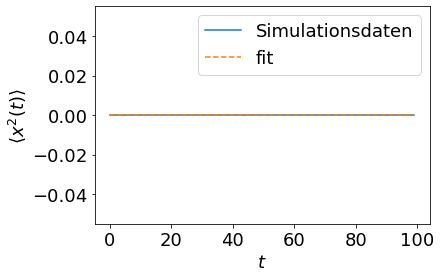

------------------------------------------
Fortschritt: 0.01
------------------------------------------
Fortschritt: 0.02
------------------------------------------
Fortschritt: 0.03
------------------------------------------
Fortschritt: 0.04
------------------------------------------
Fortschritt: 0.05
------------------------------------------
Fortschritt: 0.06
------------------------------------------
Fortschritt: 0.07
------------------------------------------
Fortschritt: 0.08
------------------------------------------
Fortschritt: 0.09
------------------------------------------
Fortschritt: 0.1
------------------------------------------
Fortschritt: 0.11
------------------------------------------
Fortschritt: 0.12
------------------------------------------
Fortschritt: 0.13
------------------------------------------
Fortschritt: 0.14
------------------------------------------
Fortschritt: 0.15
------------------------------------------
Fortschritt: 0.16
-------------------------

MovieWriter ffmpeg unavailable; using Pillow instead.


------------------------------------------
Fortschritt: 0.97
------------------------------------------
Fortschritt: 0.98
------------------------------------------
Fortschritt: 0.99


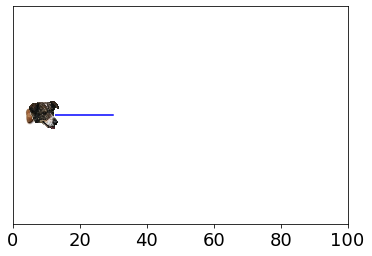

In [2]:
import fp_classes
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import time as tm

from celluloid import Camera
from datetime import date
import datetime

now = date.today().strftime("%y-%m-%dT") + datetime.datetime.now().strftime("%H_%M_%S")

env = fp_classes.environment()
learner = fp_classes.agent(env)

T_XPOW2_DATAPOINTS = dict()
T0 = tm.time()
for i in range(learner.N_episodes):
	#print(i)
	if ((i%(learner.N_episodes//100)) == 0) and i:
		progress = 1.*i/learner.N_episodes
		print("------------------------------------------")
		print(f"Fortschritt: {progress}")
		Trem = (tm.time() - T0)*(1./progress - 1.)
		print(f"Verbleibende Zeit: {Trem} s")
		#print(i)
	learner.x = 0

	for t in range(learner.tmax_MSD):
		if not t in T_XPOW2_DATAPOINTS.keys():
			T_XPOW2_DATAPOINTS[t] = []
		T_XPOW2_DATAPOINTS[t].append(learner.x**2)
		
		#AUFGABE: random_step here	


#exit()

for key in T_XPOW2_DATAPOINTS.keys():
	T_XPOW2_DATAPOINTS[key] =  np.mean(T_XPOW2_DATAPOINTS[key])

X = np.array(list(T_XPOW2_DATAPOINTS.keys()))
Y = np.array(list(T_XPOW2_DATAPOINTS.values()))
plt.rcParams.update({'font.size': 18})

fig,ax = plt.subplots()

ax.plot(X,Y,label="Simulationsdaten")
p = np.polyfit(X,Y,1)
print(p)
ax.plot(X,p[0]*X+p[1],linestyle="dashed",label="fit")
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\left <x^2(t) \right >$")
plt.show()




#exit()
LAST_TRAJECTORY = []


for episode in range(learner.N_episodes):
	if ((episode%(learner.N_episodes//100)) == 0) and episode:
		progress = 1.*episode/learner.N_episodes
		print("------------------------------------------")
		print(f"Fortschritt: {progress}")

	learner.x = env.starting_position
	learner.chosen_action = None

	while (learner.x != env.target_position) or learner.chosen_action != 1:
		if episode == learner.N_episodes-1: LAST_TRAJECTORY.append(learner.x)
		learner.adjust_epsilon(episode)
		learner.choose_action()
		learner.random_step(env)
		learner.perform_action(env)
		learner.update_Q(env)


im_agent = plt.imread("../IMG/Lasse_head.png")
im_treat = plt.imread("../IMG/treat.png")
imagebox = OffsetImage(im_agent, zoom=0.02)
imagebox2 = OffsetImage(im_treat, zoom=0.5)

trajfig,trajax = plt.subplots()
camera = Camera(trajfig)

#--------------------------------------------------------------------
#IM FOLGENDEN CODE BLOCK WIRD DIE TRAJEKTORIE ALS GIF AUSGEGEBEN
#WENN DIESER TEIL ZU LANGE DAUERT ODER SIE DIE NÖTIGEN LIBRARIES NICHT INSTALLIEREN KÖNNEN,
#KOMMENTIEREN SIE DIESEN CODE BLOCK AUS
#--------------------------------------------------------------------


LAST_TRAJECTORY_WITHOUT_PBJUMPS = []
for i in range(len(LAST_TRAJECTORY)-1):
	dx = np.abs(LAST_TRAJECTORY[i+1] - LAST_TRAJECTORY[i])
	LAST_TRAJECTORY_WITHOUT_PBJUMPS.append(LAST_TRAJECTORY[i])
	if dx > 0.5*env.N_states:
		LAST_TRAJECTORY_WITHOUT_PBJUMPS.append(None)
		

for i,x in enumerate(LAST_TRAJECTORY_WITHOUT_PBJUMPS):
	trajax.plot(np.array(LAST_TRAJECTORY_WITHOUT_PBJUMPS)[:i],np.linspace(0,0,len(np.array(LAST_TRAJECTORY_WITHOUT_PBJUMPS)[:i])),color="blue")	
	ab = AnnotationBbox(imagebox2, (env.target_position, 0.0),frameon=False)
	trajax.add_artist(ab)
	if x:
		ab = AnnotationBbox(imagebox, (x, 0.0),frameon=False)
		#trajax.add_artist(ab)
	else:
		ab = AnnotationBbox(imagebox, (LAST_TRAJECTORY_WITHOUT_PBJUMPS[i+1], 0.0),frameon=False)
	trajax.add_artist(ab)
			

	trajax.set_xlim(0.0,env.N_states)
	trajax.set_ylim(-1.0,1.0)
	trajax.set_yticks([])
	camera.snap()
animation = camera.animate()		
animation.save("LAST_TRAJECTORY_" + now + ".gif")

f = open("Q_MATRIX_" + now + ".txt","w")
f.write(str(learner.Q))
f.close()